<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code/Parameters
* Setup
    * needs
        * auth
        * gsheet auth
        * cfg_strava
* updates sheets
* Todo
    * low: error: location not found 

## Config

In [1]:
repo='https://github.com/avinashmane/colab.git'
import os,sys
if os.name=='nt':
    LIB= r'c:\m\lib'
    LOG= r'c:\m\social-media-automation'
    AUTH= r'c:\i\auth'
    sys.path.append("./lib")
else:
    if not os.path.exists('drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    LIB='/content/drive/MyDrive/m/lib'
    LOG='/content/drive/MyDrive/m/lib'
    AUTH='/content/drive/MyDrive/m/auth'
    if not os.path.exists('m'):
      !ln -sd '/content/drive/MyDrive/m/' m
    if not os.path.exists('repo'):
      !git clone $repo repo
    sys.path.append('repo')
    sys.path.append("repo/lib")
sys.path.append(LIB)


In [2]:
import yaml
cfg=yaml.load(u"""
repo:
    https://github.com/avinashmane/colab.git
packages: 
- chromium-chromedriver
modules:
- nerodia
- pygsheets
env:
    nt:
        LIB: c:/m/lib
        LOG: c:/m/social-media-automation
        AUTH: c:/i/auth
    posix:
        LIB: /content/drive/MyDrive/m/lib
        LOG: /content/drive/MyDrive/m/lib
        AUTH: /content/drive/MyDrive/m/auth
sheets:
    stravasync:
        url: https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit#gid=0
        tab: Members
        range: A10:O
    StravaPromoLog:
        url: https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit#gid=0
        tab: StravaPromoLog
        
""",Loader=yaml.Loader)
for x in cfg['env'][os.name]: 
    os.environ[x]=eval(x)

import importlib
import utils
importlib.reload(utils)
utils.setup_env(cfg['packages'],cfg['modules'])

'Environment setup'

## Code

In [3]:
import yaml
from datetime import datetime
import os
from nerodia.browser import Browser
import nerodia
import re
import logging
from IPython.display import Image

import utils

import socialmediasite 
importlib.reload(socialmediasite)
Linkedin=socialmediasite.Linkedin

# Process
## Create headless

In [4]:
" Test Selenium headless"
if True:#'b' in globals():
    if os.name=='nt':
        b=Browser('chrome',)
    else:
        
        # import sys
        # sys.path.insert(0,f'{DIR}/geckodriver')
        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    
    utils.setLogger(f"{LOG}/strava-automation.log")
    

2022-08-18 14:29:13:INFO:Logger file: c:\m\social-media-automation/strava-automation.log


In [5]:
# %debug
# if os.name=='nt':
nerodia.default_timeout=3
li=Linkedin(b,authFile=f'{AUTH}/auth.yaml')


In [6]:
li.login("avinash")

In [7]:
li.browser.url

'https://www.linkedin.com/feed/'

In [8]:
li.scrolldown(5)

In [9]:
importlib.reload(socialmediasite )
import socialmediasite

li=Linkedin(b,authFile=f'{AUTH}/auth.yaml')
utils.setLogger(f"{LOG}/strava-automation.log")

import pandas as pd
# .div(class_name='scaffold-finite-scroll').
nerodia.default_timeout=.1

def getPostData(postTag):
  "Return data regarding one post in linkedin feed"
  post={}
  if not postTag.exists:
    return
  _map={
      'post':'postTag.parent().element(class_name="visually-hidden").text',
      'urn':'postTag.attributes["data_urn"]',
      'name':'postTag.element(class_name="feed-shared-actor__name").text',
      'userUrl':'postTag.link(class_name="feed-shared-actor__container-link").href',
      'likes':'postTag.element(class_name="social-details-social-counts__reactions-count").text',
        # len('.div(class_name='feed-shared-social-actions').buttons(text='Like'))',
          # 'react-button--active' in 'react-button__text--like' in 
      'liked':'"react-button--active" in postTag.div(class_name="feed-shared-social-actions").button(text="Like").class_name',
      # print(name','.element(class_name='feed-shared-social-actions'
      #                                                            ).button(text='Like').class_name)
      'text':'postTag.element(class_name="feed-shared-update-v2__commentary").text',
      'desc':'postTag.element(class_name="feed-shared-actor__description").text',
      'subdesc':'postTag.element(class_name="feed-shared-actor__sub-description").text',
      # if post['subdesc'] not in ['Promoted']:
      'deg':'postTag.span(class_name="feed-shared-actor__supplementary-actor-info").text',
  }

  for _v,_e in _map.items():
    try:
        _m = re.search(r'.*(postTag\..*\))',_e)
        if _m:
            if eval(_m.group(1)+".exists"):
                post[_v]=eval(_e,{"postTag":postTag})
    except Exception as e:
        pass
        print(f"error {e!r} {_v} {_e}")
    
    if 'text' in post : post['text']=post['text'][:40]
    if 'userUrl' in post : post['userUrl']=post['userUrl'].split("?")[0]
    # post['liked']='react-button--active' in postTag.div(class_name='feed-shared-social-actions'
    #                                                          ).button(text='Like').class_name

  return post    

def getPostIds():
  "Get list of all feed posts"
  nerodia.default_timeout=.1
  posts=[]

  for x in b.elements(class_name='feed-shared-update-v2',
                      ):#data_id=re.compile("urn:li:activity:")):
    if re.match(r"^urn:li:activity:",x.data_urn):
        try:
            post=getPostData(x)
            post.update({'el':x})
            posts.append( post)
        except Exception as e:
          # Logs the error appropriately. 
            print(f">>{e!r}")

  return posts

posts = getPostIds() #li.


# posts=[]

# i=0
# for x in b.elements(class_name='feed-shared-update-v2',
#                     data_urn=re.compile("urn:li:activity:"),
#                    ):#data_id=re.compile("urn:li:activity:")):
#     # print (">>>",x.link(class_name="feed-shared-actor__container-link").href)
#     try:
#         print(x.h2(class_name="visually-hidden").text)
#         post=li.getPostData(x)
#         posts.append(post)
#     except Exception as e:
#         print(f"Error: {e!r}")
    # if i>3: 
    #     break
    # else:
    #     i+=1
# display (pd.DataFrame(posts))

2022-08-18 14:29:40:INFO:Logger file: c:\m\social-media-automation/strava-automation.log


In [15]:
"list posts"
display (pd.DataFrame(posts)[['name','deg','text']].style)

,name,deg,text
0,Shayan Dasgupta,• Following,Today I am happy to announce that I have
1,Simon Clarke,• 3rd+,#linkedin
2,Uneek Mehra,• 1st,Congratulations to the Myovant team and
3,E.G. Nadhan,• 2nd,If everything goes according to the comp
4,"Universal Ubiquitous Co., Ltd",nan,"Uface X, an outdoor AI Facial Recognitio"
5,Priti Arwade,• 1st,As the world was recovering from a pande
6,Arun Nathani,• 2nd,Two college friends go to a bistro. One
7,Microsoft,nan,Do you have a passion for transforming t
8,Pulin Shah,• 1st,PwC is thrilled to return to ASUG’s SAP
9,National Institute of Industrial Engineering,nan,National Institute of Industrial Enginee


ERROR! Session/line number was not unique in database. History logging moved to new session 3032


In [11]:
for p in posts:
    if ('deg' in p and 
        (p['deg']=='• 1st')):
        if(not p['liked']):
            _likeButton=p['el'].div(class_name='feed-shared-social-actions'
                                  ).button(text='Like')
            p['text']=p['text'] if 'text' in p else ''
            if _likeButton.exists:  
                logging.info(f"Liking {p['name']} {p['text'][:30]}")
                try:
                    # _likeButton.click()
                    _likeButton.execute_script("arguments[0].click();", _likeButton)
                except Exception as e:
                  # Logs the error appropriately. 
                    print(f">>{e!r}")
        else:
            logging.warning(f"already liked {p['name']} {p['text'][:30]}")
    else:
        logging.warning(f"not 1st connection {p['name']}")


2022-08-18 14:29:56:WARNING:not 1st connection Shayan Dasgupta
2022-08-18 14:29:56:WARNING:not 1st connection Simon Clarke
2022-08-18 14:29:56:INFO:Liking Uneek Mehra Congratulations to the Myovant
2022-08-18 14:29:57:WARNING:not 1st connection E.G. Nadhan
2022-08-18 14:29:57:WARNING:not 1st connection Universal Ubiquitous Co., Ltd
2022-08-18 14:29:57:WARNING:already liked Priti Arwade As the world was recovering fr
2022-08-18 14:29:57:WARNING:not 1st connection Arun Nathani
2022-08-18 14:29:57:WARNING:not 1st connection Microsoft
2022-08-18 14:29:57:INFO:Liking Pulin Shah PwC is thrilled to return to A
2022-08-18 14:29:57:WARNING:not 1st connection National Institute of Industrial Engineering
2022-08-18 14:29:57:WARNING:not 1st connection Bob Evans
2022-08-18 14:29:57:WARNING:not 1st connection Trello
2022-08-18 14:29:57:INFO:Liking bishnupada sethi 
2022-08-18 14:29:57:INFO:Liking Joseph DeBella The Temptations, with poetic l
2022-08-18 14:29:58:WARNING:not 1st connection Kakali Bhow

In [12]:
"logout"
# li.logout()

'logout'

# test linkedin

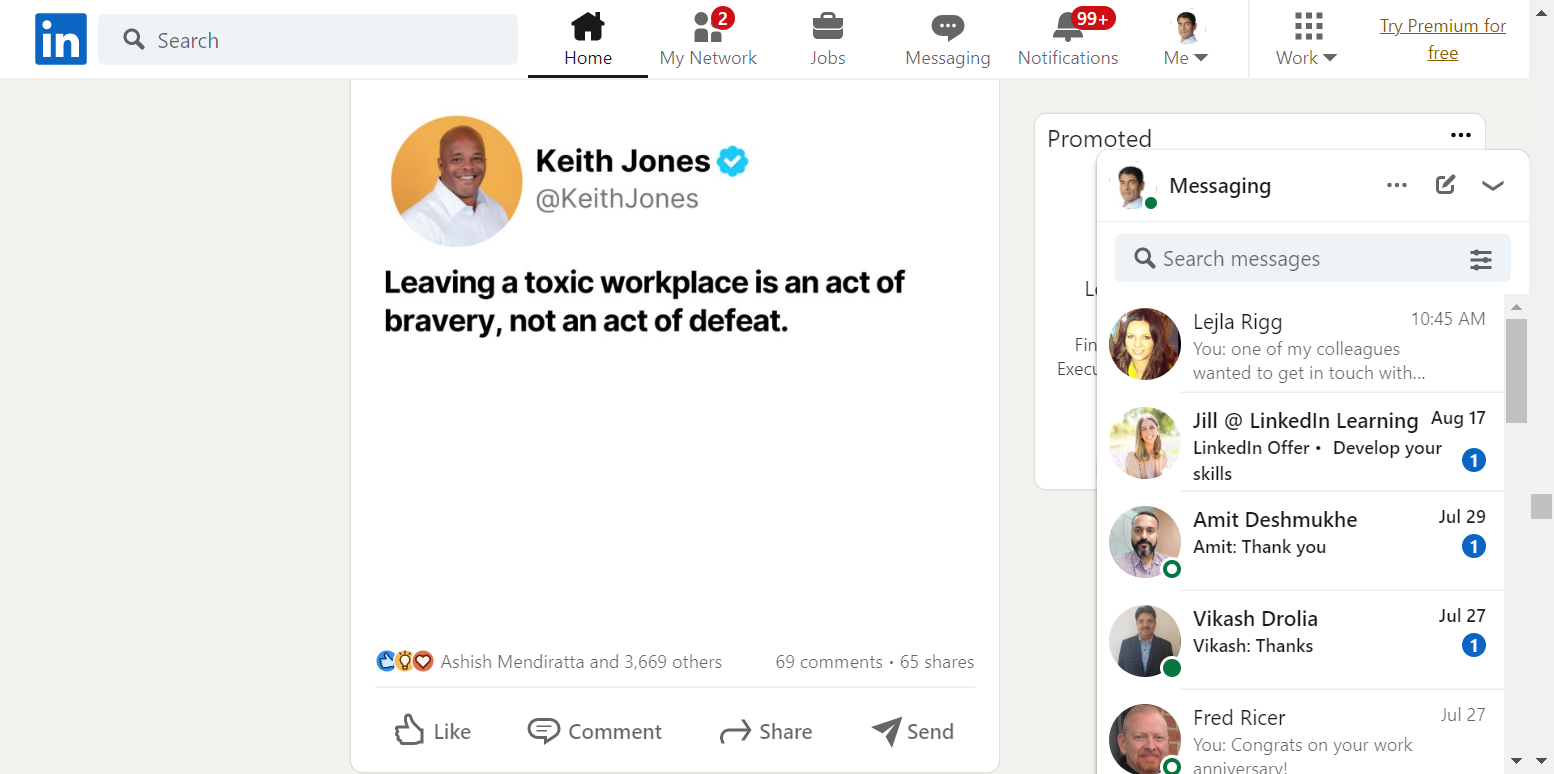

In [13]:

Image(b.screenshot.png())

## A. Give likes in feed

In [14]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')

strava.scrolldown(9)

NameError: name 'strava' is not defined

In [ ]:
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^EntryHeader')))}")

In [ ]:
strava.giveKudos()

## Give likes on Club

In [ ]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')
strava.login("strava_pcmcrunners")
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^Card')))}")
strava.giveKudos()

In [ ]:
for club in strava.cfg['pcmcrunners']['clubs']:
  strava.goto(f"{club}/recent_activity")
  logging.info(f"Total number of cards on {club} '{strava.browser.title}': {len(b.divs(class_name=re.compile('^Card')))}")
  strava.giveKudos()

# Test like

In [ ]:
import unittest
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^Card')))}")
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^EntryHeader')))}")

In [ ]:
for c_ in b.buttons(data_testid="kudos_button"):#text=re.compile('.*udos')): #'^EntryHeader')
    # print(dir(c_))
    actEl=c_.parent(class_name=re.compile('^EntryFooter')
                       ).parent()#.siblings(class_name=re.compile('^EntryHeader'))[0]
    # print(">",actEl.exists,actEl.tag_name,actEl.class_name,actEl.text[:9],)
    try:
        ath,athUrl=utils.getAttrsIfExists( actEl.link(data_testid="owners-name"),
                               ['text','href'])#,)
        loc=utils.getAttrsIfExists( actEl.div(data_testid="location"))
        act,actUrl=utils.getAttrsIfExists( actEl.link(data_testid="activity_name"),
                               ['text','href'])#,)
        kudoCount=utils.getAttrsIfExists( actEl.button(data_testid="kudos_count"))
        print(ath,athUrl,act,actUrl,kudoCount,loc)
    # ss.append_table([[pd.Timestamp.now().isoformat(),"INFO","giveKudos",id,athId,name,actId,loc,]])    
    # logging.info(f"giveKudos: {i},{id},{athId} {actId} {hdr.text.split(',')[:1]}")
        # print(">>",len(c_.elements()),
        #       c_.text.replace("\n","/")[:80],
        #      )
        # utils.dumpChildren(actEl,attr=['tag_name','class_name','text','data_testid','id'])
    except TimeoutError:
        print('timeout')
    except Exception as e:
        print (f"something else {e!r}")

In [ ]:
bs=b.elements(tag_name='a',)
len(bs)

In [ ]:
"""
This is the "example" module.

The example module supplies one function, factorial().  For example,

>>> factorial(5)
120
"""

def factorial(n):
    """Return the factorial of n, an exact integer >= 0.

    >>> [factorial(n) for n in range(6)]
    [1, 1, 2, 6, 24, 120]
    >>> factorial(30)
    265252859812191058636308480000000
    >>> factorial(-1)
    Traceback (most recent call last):
        ...
    ValueError: n must be >= 0

    Factorials of floats are OK, but the float must be an exact integer:
    >>> factorial(30.1)
    Traceback (most recent call last):
        ...
    ValueError: n must be exact integer
    >>> factorial(30.0)
    265252859812191058636308480000000

    It must also not be ridiculously large:
    >>> factorial(1e100)
    Traceback (most recent call last):
        ...
    OverflowError: n too large
    """

    import math
    if not n >= 0:
        raise ValueError("n must be >= 0")
    if math.floor(n) != n:
        raise ValueError("n must be exact integer")
    if n+1 == n:  # catch a value like 1e300
        raise OverflowError("n too large")
    result = 1
    factor = 2
    while factor <= n:
        result *= factor
        factor += 1
    return result


import doctest
doctest.testmod(verbose=False)

In [ ]:
import unittest
importlib.reload(unittest)

class Avinash(unittest.TestCase):
    def setUp(self):
        print('setup')
    def tearDown(self):
        print('teardown')
        
    def test(self):
        # date = datetime.date(2020, 1, 1)
        self.assertEqual(2+3, 5)
        
    def test2(self):
        # date = datetime.date(2019, 12, 31)
        self.assertEqual(6/2, 3)
        
res = unittest.main(argv=[''], verbosity=0, exit=False)
# if we want our notebook to stop processing due to failures, we need a cell itself to fail
assert len(res.result.failures) == 0


In [ ]:
importlib.reload(utils)
bs=b.buttons(data_testid="comment_button")
len(bs)

In [ ]:
# utils.dumpParents(bs[0])


for bs_ in bs:#bs0=bs[1]#.parent(class_name='EntryHeader--entry-header--lXRRn')
    postComment(bs_)
# utils.dumpTag(bs0)

    
# utils.dumpTag(bs0)
# utils.dumpChildren(bs0.parent(data_testid='kudos_comments_container'),"tag_name|class_name|text|title|data_testid".split('|'))

In [ ]:
ta.value='Nice!'

In [ ]:
dir(bs0)

In [ ]:
bs0=bs[0].parent(class_name='EntryHeader--entry-header--lXRRn')
for i in range(5):
    bs0=bs0.parent()
    utils.dumpTag(bs0)

In [ ]:
dir(bs[0].el)

In [ ]:
importlib.reload(utils)
len(bs)
utils.dumpChildren(bs0,attr=['tag_name','class_name','text','data_testid'])

In [ ]:
utils.dumpParents(bs[0])

# Test post

In [ ]:
## Comment on PCMC club
strava.goto("https://www.strava.com/clubs/196654/recent_activity")

In [ ]:
card=strava.getParent(x1[0],'div','^Card')

In [ ]:
card.text
[x.link().text for x in [card.div(class_name=re.compile("^MediaBody--media-body--"))]]

In [ ]:
KudosButtons=strava.browser.buttons(title=strava.giveKudosPattern)
for i,x in enumerate(KudosButtons):
  try:
    card=strava.getParent(x,'div','^Card')
    athId,ath=SocialMediaSite.getLinkByClassPatt(card,"^Avatar--")
    actId,_=SocialMediaSite.getLinkByClassPatt(card,"^ActivityEntryBody--")
    for x in card.divs(class_name=re.compile("^MediaBody--media-body--")):
        name=x.link().text
        if x.exists:
            locEl=x.div(class_name=re.compile('^LocationAndTime--location--',)).wait_until(timeout=0.1, method=lambda _: True)
            loc=locEl
    # text=card.text.split(',')[:1]
    print(name,loc)
    # x.click() 
    try:
        x = int(re.findall(".*\/([0-9]*)",athId)[0])
        if x not in StravaMembers:
            x='nonMember'
    except:
        x='not valid'

    # self.browser.execute_script("arguments[0].click();", x)
    ss.append_table([[pd.Timestamp.now().isoformat(),"INFO","Comments",x,athId,name,actId,loc,]])    
    logging.info(f"giveKudos: {i},{x} {athId} {actId} {name}")
  except Exception as e: 
    logging.warning(f"giveKudos: {i} error clicking {e!r}")


In [ ]:
b.link(href="#container-nav").click()

In [ ]:
b.button(title="Expand profile menu").hover()

In [ ]:
[(x.text,x.class_name,x.tag_name) for x in b.button(title="Expand profile menu").span().span()]

In [ ]:
# b.execute_script("window.scrollTo(0,0)")
# Image(b.screenshot.png())
re.findall(".*\/([0-9]*)","https://www.strava.com/athletes/27331750")[0]

In [ ]:
"get all attributes"
# for x in dir(b):
#   print(x,type(getattr(b,x)),)

# New section
